In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.fft as fft
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.stats import levy
from iminuit import Minuit
from scipy.optimize import curve_fit

## Parameters and initial conditions

In [2]:
'''
Good conditions - good ttcf and g2:

dim = 750 #[nm]
N = 35
radius = 10 #[nm]
bounds = (0 + radius, dim - radius)
diff = 1.0

#Detector parameters
s_dim = 2000 #[um]
dev = 50
roi_params = [100,300]

temp = 50

p_amount = int(N * 0.1) #How many particles to move
step_size = [5,10] #Size of step
''';

In [3]:
#sample parameters

dim = 1000 #[nm]
N = 100
radius = 10 #[nm]
bounds = (0 + radius, dim - radius)
diff = 1.0
dev = 50

#Detector parameters
s_dim = 2000 #[um]

#roi_params = [int(dim / 10), int(dim / 3)]
roi_params = [80,100]


#movement params
p_amount = int(N * 0.1) #How many particles to move
step_size = [3,7] #Size of step

n_frames = 100 #Amoun of images to generate
ttdt = np.linspace(0, 4.361e-05, n_frames-1)

In [4]:
conc = (np.pi * radius ** 2 * N) / (dim ** 2) #check concentration
conc

0.031415926535897934

## Sample functions

In [5]:
def p_locs(N, dev, min_distance): #Create sample with normal distribution   
    positions = []
    center = [(bounds[0] + bounds[1]) / 2, (bounds[0] + bounds[1]) / 2]  # Center of the bounds

    while len(positions) < N:
        # Generate new position with a normal distribution centered at the center
        new_pos = np.random.normal(loc = center, scale = dev, size = (2,))
        #new_pos = np.random.uniform(low = bounds[0] + 4 * radius, high = bounds[1] - 4 * radius, size = (2,))
        
        # Ensure new position is within bounds
        if (bounds[0] + radius <= new_pos[0] <= bounds[1] - radius) and (bounds[0] + radius <=
                                                                         new_pos[1] <= bounds[1] - radius):
            # Check distances from existing particles
            if len(positions) > 0:
                distances = np.linalg.norm(new_pos - np.array(positions), axis=1)
                if np.all(distances >= min_distance):
                    positions.append(new_pos)
            else:
                positions.append(new_pos)

    return np.array(positions)

def sample(locs, radius): #Places the particle's location in a matrix - creating the sample matrix
    sample = np.zeros((dim, dim))
    for i in range(len(locs)):
        xx, yy = np.meshgrid(range(dim), range(dim))
        dist_squared = (xx - locs[:,0][i]) ** 2 + (yy - locs[:,1][i]) ** 2
        sample[dist_squared <= radius ** 2] = 1
    
    return sample

In [6]:
#Generate particle coordinates
particle_loc = p_locs(N, dev, 2 * radius)

#Generate sample matrix
init_sample = sample(particle_loc, radius)

Text(0.5, 1.0, 'Initial positions in the sample')

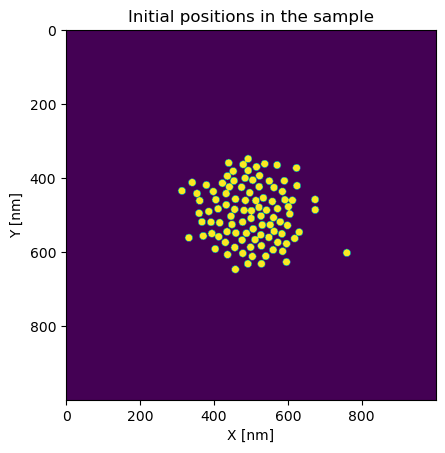

In [7]:
plt.imshow(init_sample) #Image of sample matrix
plt.xlabel('X [nm]')
plt.ylabel('Y [nm]')
plt.title('Initial positions in the sample')
#plt.savefig('pics/init_pos_brown.png', dpi = 300)

## Brownian motion

In [8]:
def brown_motion(ip, step, diff, bounds, p_amount):
    # Set up
    old_positions = np.copy(ip)
    new_positions = np.copy(ip)  
    
    # Moving x amount of particles
    parts = np.random.randint(0, len(ip), p_amount)  # which particles to move

    for i in range(len(parts)):
        step_size = np.random.randint(step[0], step[1], 1)  # Step size of particle
        p_step = np.random.normal(scale = np.sqrt(2 * diff * step_size), size=2)  # Change coordinate
        new_positions[parts[i]] = ip[parts[i]] + p_step

         #Boundary conditions - periodic
        if new_positions[parts[i]][0] + radius > bounds[1]:
            new_positions[parts[i]][0] = bounds[0] + radius
        elif new_positions[parts[i]][0] - radius < bounds[0]:
            new_positions[parts[i]][0] = bounds[1] - radius
        if new_positions[parts[i]][1] + radius > bounds[1]:
            new_positions[parts[i]][1] = bounds[0] + radius
        elif new_positions[parts[i]][1] - radius < bounds[0]:
            new_positions[parts[i]][1] = bounds[1] - radius
        
       # 
       # #Hard boundaries
       # if new_positions[parts[i]][0] + radius > bounds[1]:
       #     new_positions[parts[i]][0] = bounds[1] - radius
       # elif new_positions[parts[i]][0] - radius < bounds[0]:
       #     new_positions[parts[i]][0] = bounds[0] + radius
       # if new_positions[parts[i]][1] + radius > bounds[1]:
       #     new_positions[parts[i]][1] = bounds[1] - radius
       # elif new_positions[parts[i]][1] + radius < bounds[0]:
       #     new_positions[parts[i]][1] = bounds[0] + radius
            
    # Collision avoidance, if their trajectories collide - they go back to their old position
    for i in range(len(new_positions)):
        for j in range(i + 1, len(new_positions)):
            dist = np.linalg.norm(new_positions[i] - new_positions[j])
            if dist == 0:
                dist = 2 * radius + 1
            elif dist < 2 * radius:
                new_positions[i] = old_positions[i]
                new_positions[j] = old_positions[j]

    return new_positions, old_positions


In [9]:
new_pos, old_pos = brown_motion(particle_loc, step_size, diff, bounds, p_amount)

In [10]:
brown_samp = sample(new_pos, radius) #generate image of altered sample

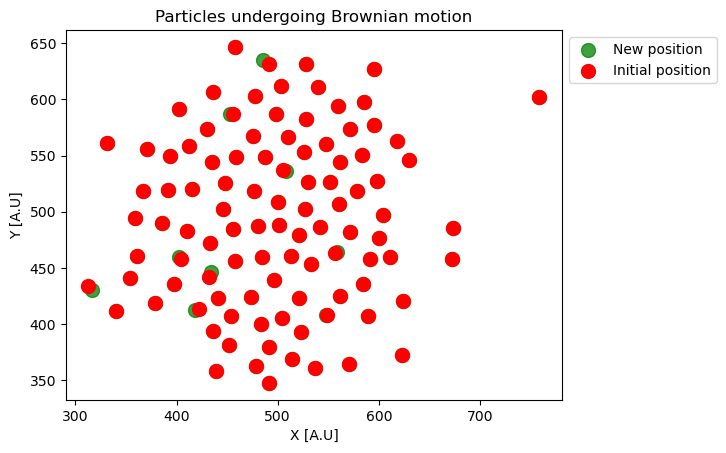

In [11]:
#to see difference

plt.scatter(new_pos[:,0], new_pos[:,1], color = 'green', alpha = 0.75, s = 100,
           label = 'New position')
plt.scatter(particle_loc[:,0], particle_loc[:,1], color = 'red', s = 100, 
           label = 'Initial position')
plt.xlabel('X [A.U]')
plt.ylabel('Y [A.U]')
plt.title('Particles undergoing Brownian motion')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.savefig('pics/Brown_motion.png', dpi=300, bbox_inches='tight')

## Create frames

In [12]:
def frame_generator_brown(particle_loc, n_frames):
    n = 0
    il = np.copy(particle_loc)
    nl = []
    while n < n_frames: #n X N new particle locations
        new_l, old_l = brown_motion(il, step_size, diff, bounds, p_amount)
        nn = np.vstack(new_l)
        nl.append(nn)
        il = nn
        n += 1
    
    frames = []
    for i in range(len(nl)):
        fr = sample(nl[i], radius)
        frames.append(fr)
    return frames

In [13]:
frames = frame_generator_brown(particle_loc, n_frames)

In [14]:
def animation(frames, show = False):
    if show == True:
        num_frames = len(frames)
        fig, ax = plt.subplots()
        im = ax.imshow(frames[0], cmap='viridis')
        temp_text = ax.text(0.05, 0.95, '', transform = ax.transAxes, 
                              color = 'white', fontsize = 12, ha = 'left', va = 'top')
        #rad_text = ax.text(0.1, 0.95, '', transform = ax.transAxes,
        #                      color = 'white', fontsize = 12, ha = 'left', va = 'top')
        
        def update(frame):
            im.set_array(frames[frame]) 
            #temp_text.set_text(f'Temperature: {np.round(temps[frame], 2)} K')
            #rad_text.set_text(f'Radius: {np.round(rad[frame], 2)} nm')
            return [im]
    
        ani = FuncAnimation(fig, update, frames=num_frames, interval=150, blit=True)
        return HTML(ani.to_jshtml())
    else:
        return plt.imshow(frames[0])

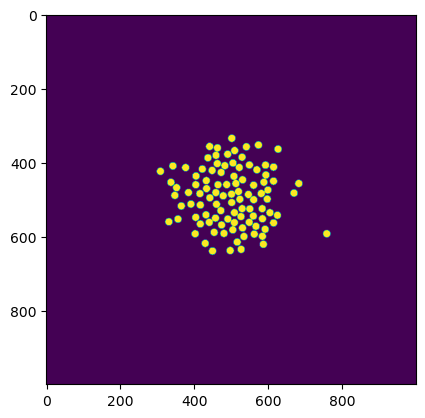

In [15]:
animation(frames, show = True)

## Beam

In [16]:
#---------Defining image extents---------# 
pixelspace = dim/2                                                # in units of pixels
pixel_extent = [-pixelspace, pixelspace, -pixelspace, pixelspace]

sample_pixel_size = dim * 10e-9 #Dim in [nm] to [m]
realspace = (sample_pixel_size * (dim/2))                         # [currently m]
real_extent = [-realspace, realspace, -realspace, realspace]

recipspace = (2 * np.pi / realspace)                               # in units of 'a' [currently AA]
recip_extent = [-recipspace, recipspace, -recipspace, recipspace]

In [17]:
# Define sample parameters
pixel_size = 10 # Pixel size
sample_detector_distance = 8e6  # Sample-detector distance 
wavelength = 1.8 # Wavelength in aa

# Define scattering vector components (in reciprocal space)
ny, nx = init_sample.shape
qy, qx = np.meshgrid(np.fft.fftfreq(ny, pixel_size), np.fft.fftfreq(nx, pixel_size), indexing='ij')
q = np.sqrt(qx ** 2 + qy ** 2)

# Calculate scattering intensity
sc_intens = np.abs(fft.fft2(init_sample)) ** 2
sc_intens_q = np.fft.fftshift(np.fft.fft2(init_sample))

# XFEL beam
beam_profile = np.exp(- (q ** 2) / (4 * (1 / wavelength) ** 2))

# Simulate beam-sample interaction
intens = fft.fftshift(fft.ifft2(fft.fft2(sc_intens) * fft.fft2(beam_profile)))
intens_q = fft.fftshift(fft.ifft2(fft.fft2(sc_intens_q) * fft.fft2(beam_profile)))

# Generate speckle pattern 
spek = np.abs(intens)**2
speq = np.abs(intens_q)**2

In [18]:
q_extent = [qx.min(), qx.max(), qy.min(), qy.max()]
arrq = np.linspace(0, qx.max(), n_frames)

In [19]:
q_extent = [qx.min(), qx.max(), qy.min(), qy.max()]
arrq = np.linspace(0, qx.max(), n_frames)

In [20]:
print(q_extent)

[-0.05, 0.0499, -0.05, 0.0499]


In [21]:
#Function for creating 

def speck_q(frames):
    spekls = []
    speqls = []
    for i in range(len(frames)):
        sp = frames[i] 

        ny, nx = sp.shape
        qy, qx = np.meshgrid(np.fft.fftfreq(ny, pixel_size), np.fft.fftfreq(nx, pixel_size), indexing='ij')
        q = np.sqrt(qx**2 + qy**2)


        sc_intens = np.abs(fft.fft2(sp))**2
        sc_intens_q = np.fft.fftshift(np.fft.fft2(sp))


        beam_profile = np.exp(-(q**2) / (4 * (1 / wavelength)**2))


        intens = fft.fftshift(fft.ifft2(fft.fft2(sc_intens) * fft.fft2(beam_profile)))
        intens_q = fft.fftshift(fft.ifft2(fft.fft2(sc_intens_q) * fft.fft2(beam_profile)))


        spek = np.abs(intens)**2
        speq = np.abs(intens_q)**2

        spekls.append(spek)
        speqls.append(speq)

    return spekls, speqls
        

In [22]:
%%time
speks, speqs = speck_q(frames) #SAXS patterns

CPU times: user 12.2 s, sys: 306 ms, total: 12.5 s
Wall time: 12.6 s


In [23]:
q_extent

[-0.05, 0.0499, -0.05, 0.0499]

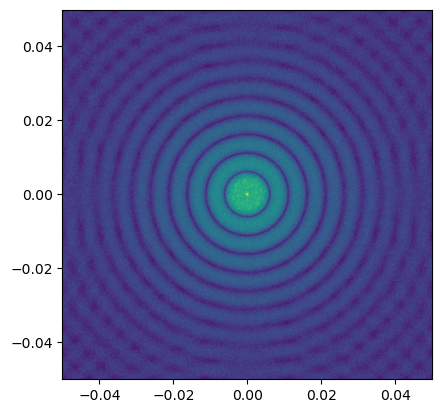

In [24]:
plt.imshow(np.log(np.mean(speqs, axis = 0)), extent = q_extent)
#plt.xlim(-0.15,0.15)
#plt.ylim(-0.15,0.15)

## Azimuthal integration

In [25]:
#Azimuthal integration
import math as m
image = (speqs[0])

center = (dim/2, dim/2)
d = m.floor(np.sqrt(center[0] ** 2 + center[1] ** 2))

centered = np.meshgrid(np.arange(dim) - center[0], np.arange(dim) - center[1])
rad = np.sqrt((centered[0] ** 2) + (centered[1] ** 2))

r = np.linspace(1, int(center[0]) + 1, int(center[0]))

d = lambda r : image[(rad >= r - 0.5) & (rad < r + 0.5)].mean()


In [26]:
def azimuthal_int(image):
    im = image
    center = (dim/2, dim/2)
    d = m.floor(np.sqrt(center[0] ** 2 + center[1] ** 2))
    
    centered = np.meshgrid(np.arange(dim) - center[0], np.arange(dim) - center[1])
    rad = np.sqrt((centered[0] ** 2 + (centered[1] ** 2)))
                  
    r = np.linspace(1, int(center[0]) + 1, int(center[0]))
                  
    d = lambda r : im [(rad >= r - 0.5) & (rad < r + 0.5)].mean()
                  
    mean_d = np.vectorize(d)(r)
    
    return mean_d

In [27]:
azz = azimuthal_int(speqs[0])
from scipy.signal import find_peaks

peaks, _ = find_peaks(azz, distance = 30)
peaks
p_x = np.linspace(0,len(azz),len(peaks))

In [28]:
pp = np.linspace(0, int(dim/2), int(dim/2))

In [29]:
rois = []
for i in range(1, len(peaks)):
    l_roi = pp[peaks[i]] - 5
    u_roi = pp[peaks[i]] + 5
    rois.append([int(l_roi), int(u_roi)])

In [30]:
q_azim = np.linspace(0.001, qx.max(), len(azimuthal_int(speqs[0])))

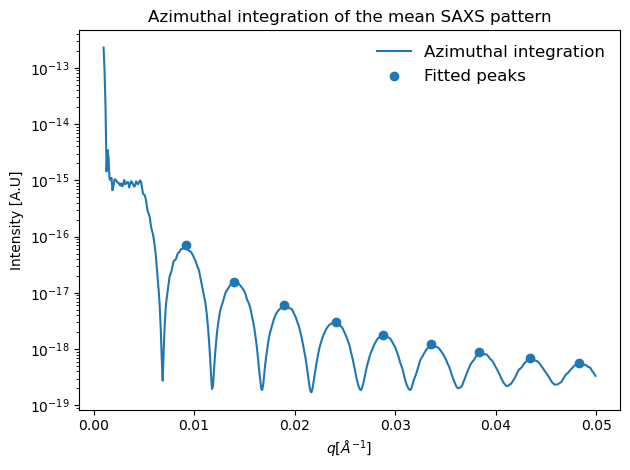

In [136]:
plt.plot(q_azim, azimuthal_int(np.mean(speqs, axis = 0)), label = 'Azimuthal integration')
plt.scatter(q_azim[peaks][2:], azz[peaks][2:], label = 'Fitted peaks')
plt.title('Azimuthal integration of the mean SAXS pattern')
plt.ylabel('Intensity [A.U]')
plt.xlabel(r'$q [Å^{-1}]$')
plt.yscale('log')
plt.legend(fontsize=12, loc='upper right', frameon=False)
# Layout adjustment
plt.tight_layout()
#plt.xlim(0,0.15)
plt.savefig('pics/azim_sim_1.png', dpi = 300)

In [32]:
mean_d = np.vectorize(d)(r)

In [33]:
def sinc_func(x, amplitude, frequency, phase, offset):
    return (amplitude * np.sinc(frequency * (x - phase))) + offset

def chi2_sinc(amplitude, frequency, phase, offset):
    model = sinc_func(q_azim, amplitude, frequency, phase, offset)
    return np.sum(((mean_d - model) / np.std(mean_d)) ** 2)

azim_fit = Minuit(chi2_sinc, amplitude = max(mean_d), frequency = 50, phase = 10, offset = min(mean_d))
azim_fit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 496.3                      │              Nfcn = 104              │
│ EDM = 0.000124 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ amplitude │  2.2e-12  │  1.1e-12  │            │            │         │         │       │
│ 1 │ frequency │   50.05   │   0.25    │            │            │         │         │       │
│ 2 │ phase     │   10.00   │   0.05    │            │            │         │         │       │
│ 3 │ offset    │  0.6e-15  │  0.5e-15  │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────────────────────────────┐
│           │            amplitude            frequency                phase               offset │
├───────────┼─────────────────────────────────────────────────────────────────────────────────────┤
│ amplitude │             1.28e-24     2.2070587375e-15     -828.5837387e-18           -77.08e-30 │
│ frequency │     2.2070587375e-15               0.0631              -0.0126 -522.82914793365e-21 │
│     phase │     -828.5837387e-18              -0.0126              0.00252 -169.30348886690e-21 │
│    offset │           -77.08e-30 -522.82914793365e-21 -169.30348886690e-21             2.58e-31 │
└───────────┴─────────────────────────────────────────────────────────────────────────────────────┘

In [34]:
def sin_func(x, aa, dd, ff, pp, oo):
    fx = aa * np.exp(-dd * x) * (np.sin((ff * x) - pp)) + oo
    return fx

def chi2_sin(aa, dd, ff, pp, oo):
    model = sin_func(q_azim, aa, dd, ff, pp, oo)
    return np.sum(((mean_d - model) / np.std(mean_d)) ** 2)

fit_sin = Minuit(chi2_sin, aa = max(mean_d), dd = 10, ff = 50, pp = 10, oo = min(mean_d))
fit_sin.migrad();

def ffactor(q,r, off):
    fx = (( 3 / (q * r) ** 3 ) *  np.sin(q * r) - q * r * np.cos(q * r)) ** 2 + off
    return fx

def chi2_ff(r, off):
    model = ffactor(q_azim, r, off)
    return np.sum(((mean_d - model) / np.std(mean_d)) ** 2)
    
fit_ff = Minuit(chi2_ff, r = 1, off = 1)
fit_ff.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.136e+34                  │             Nfcn = 1100              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ r    │ 3.0811e2  │    nan    │            │            │         │         │       │
│ 1 │ off  │ -4.5026e1 │    nan    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────┐
│     │   r off │
├─────┼─────────┤
│   r │ nan nan │
│ off │ nan nan │
└─────┴─────────┘

In [35]:
amp, freq, phase, off = azim_fit.values
y_azim = sinc_func(q_azim, amp, freq, phase, off)

aa, dd, ff, pe, oo = fit_sin.values
sin_azim = sin_func(q_azim, aa, dd, ff, pe, oo)

R, ofof = fit_ff.values
fit_r = ffactor(q_azim, R, ofof)

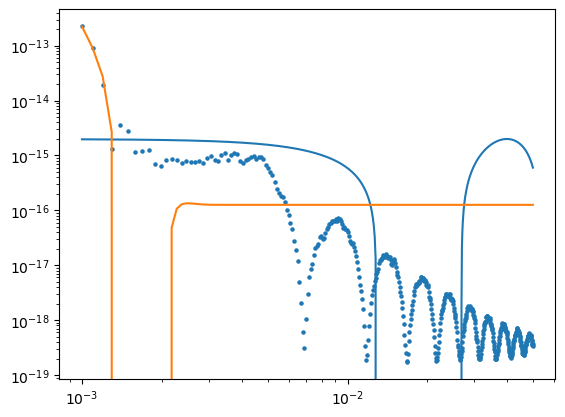

In [36]:
plt.scatter(q_azim, (mean_d), s = 5)
plt.plot(q_azim, (y_azim))
plt.plot(q_azim, sin_azim)
plt.yscale('log')
#plt.plot(q_azim, y_od)

plt.xscale('log')
#plt.ylim(-0.11e-7, 0.2e-7)

## ROIs

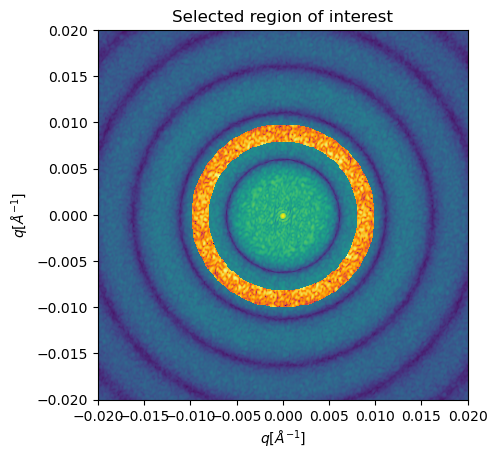

In [137]:
#Creating a ROI



x, y = np.ogrid[:dim, :dim]
c_dist = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
mask = (c_dist <= roi_params[1]) & (c_dist >= roi_params[0])

c_roi = np.zeros_like(speqs[0])
c_roi[mask] = speqs[0][mask]

plt.imshow(np.log(np.mean(speqs, axis = 0)), extent = q_extent)
plt.imshow(np.log(c_roi), extent = q_extent, cmap = 'inferno')
#plt.colorbar()
plt.xlim(-0.02,0.02)
plt.ylim(-0.02,0.02)
plt.xlabel(r'$q [Å^{-1}]$')
plt.ylabel(r'$q [Å^{-1}]$')
plt.title('Selected region of interest')
plt.savefig('pics/roi_1.png', dpi = 300)

In [38]:
c_roi[mask].shape

(11348,)

In [39]:
#Function to calculate get rois

def roi(upper, lower, speqs):
    roi = [upper, lower]
    
    x, y = np.ogrid[:dim, :dim]
    c_dist = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    mask = (c_dist <= roi[1]) & (c_dist >= roi[0])
    
    rois = []

    for i in range(len(speqs)):
        mat = np.zeros_like(speqs[i])
        mat[mask] = speqs[i][mask]
        rois.append(mat[mask])
        
    return np.array(rois)

In [40]:
rr = []
for i in range(len(rois)):
    rr.append(roi(rois[i][0], rois[i][1], speqs))
    

In [41]:
ones = np.ones(np.shape(speqs))
same = ones * speqs[0]

In [42]:
w = roi(roi_params[0], roi_params[1], (speqs))
w_s = roi(roi_params[0], roi_params[1], same)

In [43]:
ttcf = np.matmul(w, w.T)
ttcf_s = np.matmul(w_s, w_s.T)

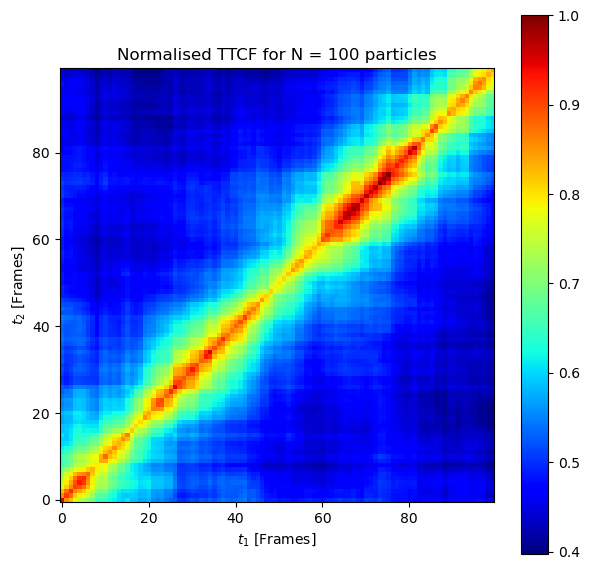

In [44]:
plt.figure(1, figsize = (7,7))
plt.imshow(ttcf/ttcf.max(), cmap = 'jet', origin = 'lower')
plt.colorbar()
plt.title('Normalised TTCF for N = {} particles'.format(N)) 
                                                            
#print(np.mean(ttcf))
plt.xlabel(r'$t_{1}$ [Frames]')
plt.ylabel(r'$t_{2}$ [Frames]')
plt.savefig('pics/ttcf_sim.png', dpi = 300)

## G2

In [45]:
def get_cf(darr,skip_last=0):
    return np.array([np.nanmean(np.diagonal(darr,offset=i)) for i in range(1,len(darr)-skip_last)])

def e_decay(dt,Gm,beta,off):
    g1 = np.exp(-Gm*dt)
    g2 = beta*g1**2+off
    return g2

g2 = get_cf(ttcf/ttcf.max())
t_steps = np.linspace(0, len(g2), len(g2))

y_err = np.std(g2) 

In [46]:
def chi2(Gm,beta,off):
    y_exp = e_decay(t_steps,Gm,beta,off)
    chi2 = np.sum(((g2 - y_exp) / np.std(g2))**2)
    return chi2

def g2_fit(g2):
    gm = []
    b = []
    k = []
    chi = []
    unc = []

    def chi2(Gm,beta,off):
        y_exp = e_decay(ttdt,Gm,beta,off)
        chi2 = np.sum(((g2[i] - y_exp) / np.std(g2[i]))**2)
        return chi2
    
    for i in range(len(g2)):
        fit = Minuit(chi2, Gm = 5, beta = g2[i][0], off = min(g2[i]))
        fit.migrad()
        gg, bb, of = fit.values
        gm.append(gg)
        b.append(bb)
        k.append(of)
        chi.append(fit.fval)
        unc.append(fit.errors[0])
    return gm, b, k, chi, unc

In [47]:
fit = Minuit(chi2, Gm = 5, beta = g2[0], off = min(g2))
fit.migrad()
fit.errors

<ErrorView Gm=0.008199899440733044 beta=0.04668818425055848 off=0.013268866244059044>

In [48]:
Gm, beta, off = fit.values
gm_unc, beta_unc, off_unc = fit.errors
fit_curve = e_decay(t_steps, Gm, beta, off)
chi2_val = np.round(fit.fval,2)

In [49]:
print(Gm, 'pm', gm_unc)

0.0377897502233414 pm 0.008199899440733044


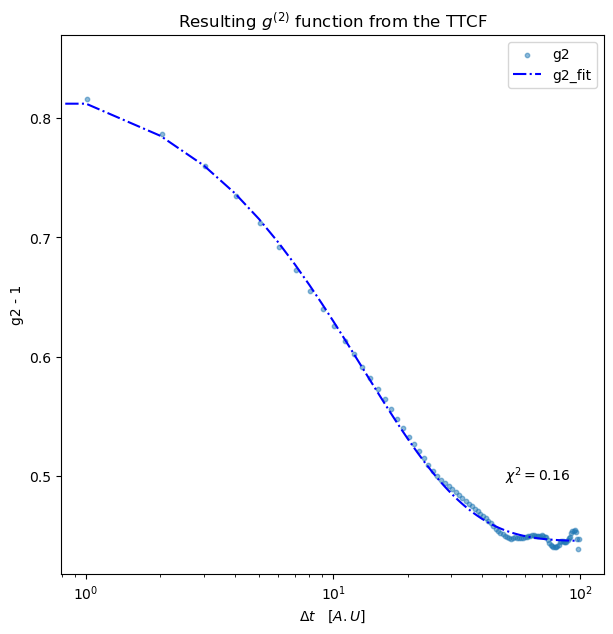

In [50]:
plt.figure(1, figsize = (7,7))

plt.scatter(t_steps, g2, s = 10,label = 'g2', alpha = 0.5)
            
plt.plot(fit_curve, color = 'b', alpha = 1, label = 'g2_fit', ls = '-.')
plt.ylabel('g2 - 1')
plt.xlabel(r'$\Delta t \quad [A.U]$')
plt.text(x = len(g2) - len(g2)/2, y = g2[-1] + 0.05, s = r'$\chi^{} = {}$'.format(2,chi2_val));
plt.xscale('log')
plt.legend()
plt.title(r'Resulting $g^{(2)}$ function from the TTCF')
plt.savefig('pics/g2_1.png', dpi = 300)

In [51]:
fit_params = ['Gm: Decay rate','beta: Contrast','off: Offset']
for i in range(len(fit.values)):
    print(fit_params[i],np.round(fit.values[i],4))

Gm: Decay rate 0.0378
beta: Contrast 0.3956
off: Offset 0.4456


In [52]:
for i in range(len(fit.errors)):
    print(fit_params[i], np.round(fit.errors[i]), 5)

Gm: Decay rate 0.0 5
beta: Contrast 0.0 5
off: Offset 0.0 5


## Multiple ROIs

In [53]:
rois = []
q_vals = []
for i in range(0, len(peaks)):
    l_roi = pp[int(peaks[i])] - 2
    u_roi = pp[int(peaks[i])] + 2
    print(l_roi, u_roi)
    rois.append([int(l_roi), int(u_roi)])
    q_val = [q_azim[int(l_roi)], q_azim[int(u_roi)]]
    q_vals.append(q_val)

2.008016032064128 6.008016032064128
33.07014028056112 37.07014028056112
82.16833667334669 86.16833667334669
130.2645290581162 134.2645290581162
181.36673346693385 185.36673346693385
234.47294589178355 238.47294589178355
282.5691382765531 286.5691382765531
330.6653306613226 334.6653306613226
379.7635270541082 383.7635270541082
431.86773547094185 435.86773547094185
480.9659318637274 484.9659318637274


In [54]:
rr = []
for i in range(len(rois)):
    rr.append(roi(rois[i][0], rois[i][1], speqs))

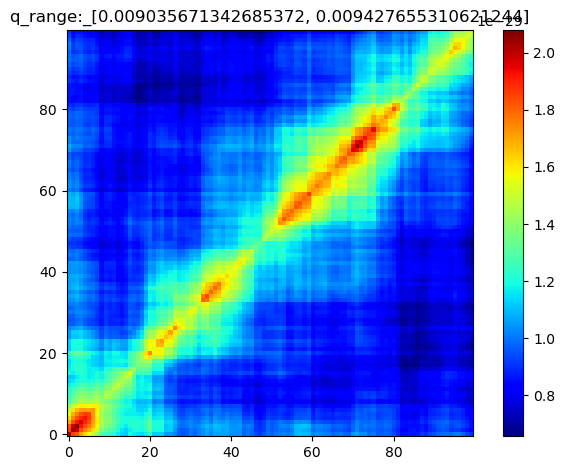

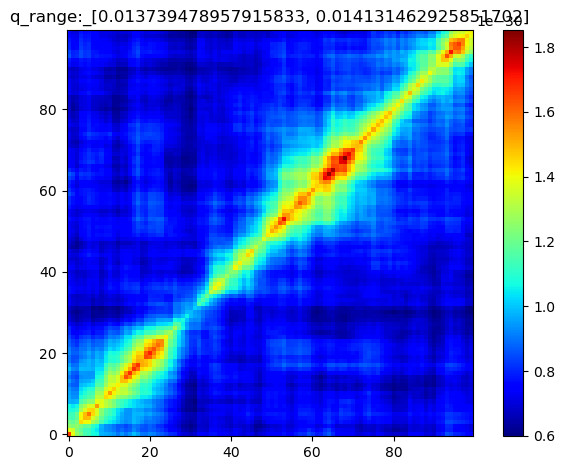

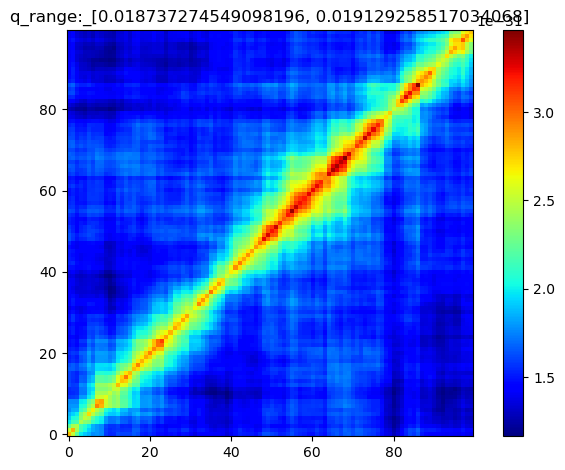

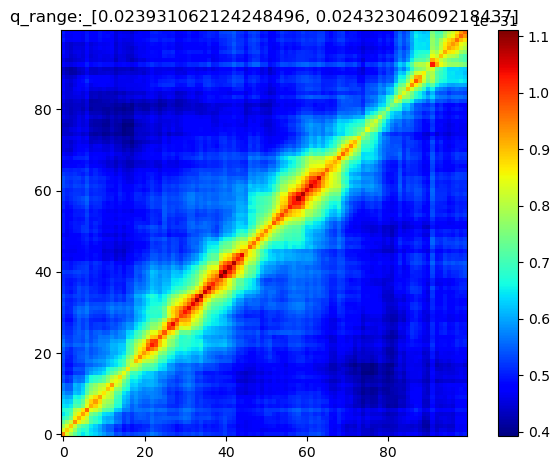

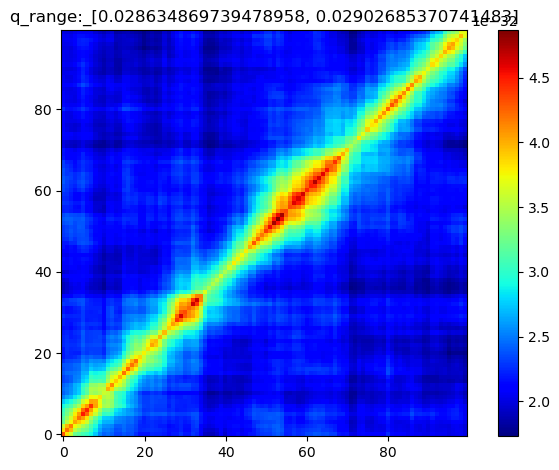

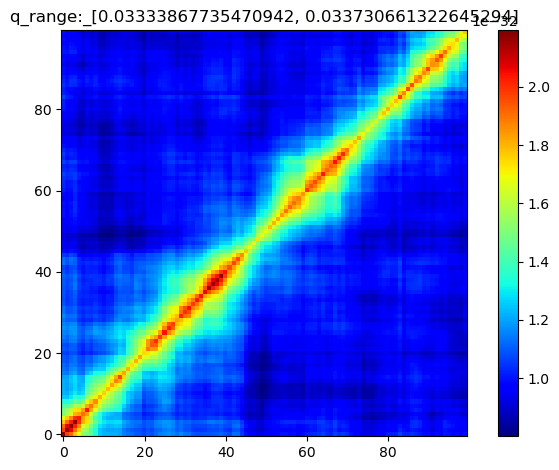

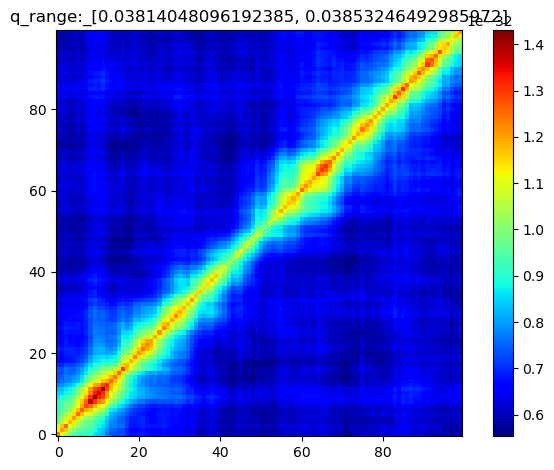

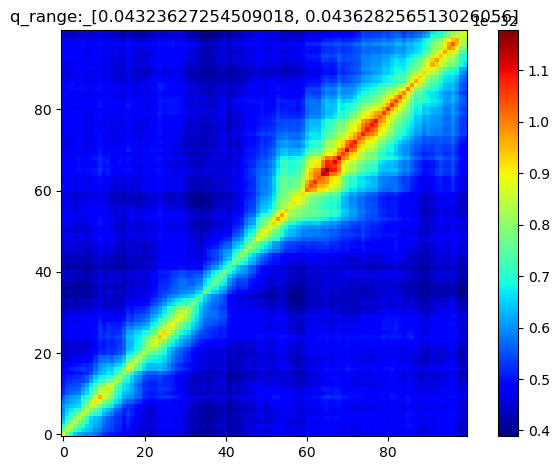

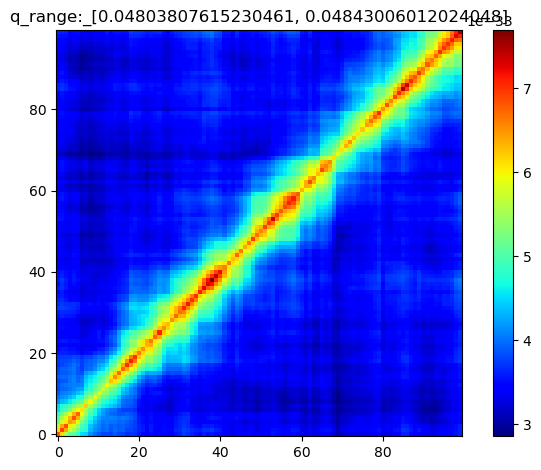

In [55]:
for i in range(2,len(rr)):
    plt.figure(i)
    plt.imshow(np.matmul(rr[i], rr[i].T), cmap = 'jet', origin = 'lower')
    plt.title('q_range:_{}'.format(q_vals[i]))
    plt.colorbar()
    plt.tight_layout()

In [56]:
g2s = []
for i in range(2,len(rr)):
    ttcf = np.matmul(rr[i], rr[i].T)
    g = get_cf(ttcf / ttcf.max())
    g2s.append(g)

In [57]:
gms, bs, ks, chis, uncs = g2_fit(g2s)

In [58]:
q_vals
qqdq = np.array(q_vals)[:,0]

In [59]:
qqdq

array([0.00119599, 0.00423387, 0.00903567, 0.01373948, 0.01873727,
       0.02393106, 0.02863487, 0.03333868, 0.03814048, 0.04323627,
       0.04803808])

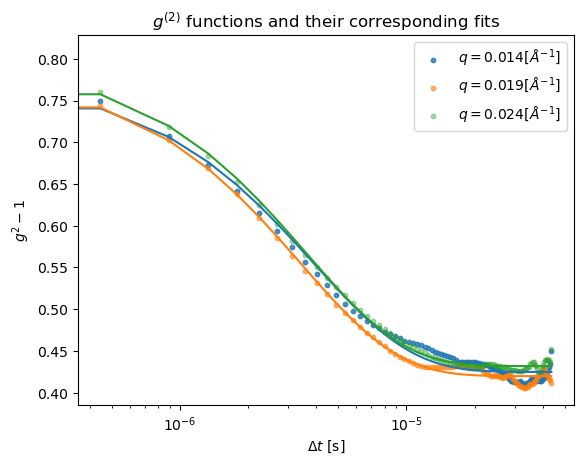

In [88]:
alpha = [0.8, 0.6, 0.4]
for i in range(0,3):
    plt.scatter(ttdt, g2s[i + 3], label = r'$q ={}{}$'.format(np.round(qqdq[i+3], 3), r'[Å^{-1}]'), s = 10, alpha = alpha[i])
    plt.plot(ttdt, e_decay(ttdt, gms[i+3], bs[i+3], ks[i+3]))
    plt.xscale('log')
    plt.xlabel(r'$\Delta t$ [s]')
    plt.ylabel(r'$g^{2} - 1$')
plt.legend()
plt.title(r'$g^{(2)}$ functions and their corresponding fits')
plt.savefig('pics/g2_sim_3_1.png', dpi = 300)

In [61]:
rois

[[2, 6],
 [33, 37],
 [82, 86],
 [130, 134],
 [181, 185],
 [234, 238],
 [282, 286],
 [330, 334],
 [379, 383],
 [431, 435],
 [480, 484]]

In [62]:
np.array(gms[2:]) / 1e6

array([0.1275998 , 0.12837767, 0.14649347, 0.13879884, 0.1538549 ,
       0.14913378, 0.15712779])

In [63]:
(qqdq[2:])

array([0.00903567, 0.01373948, 0.01873727, 0.02393106, 0.02863487,
       0.03333868, 0.03814048, 0.04323627, 0.04803808])

In [64]:
np.array(chis[2:]) 

array([5.33108194, 1.79264868, 0.73800985, 0.3486023 , 0.78927648,
       0.83630317, 0.87138153])

In [65]:
np.array(uncs[2:]) / 1e6

array([0.03165698, 0.03003518, 0.03105398, 0.02915076, 0.03123799,
       0.02948472, 0.03205988])

In [66]:
gms

[86739.12514509307,
 140349.70646571083,
 127599.79873722016,
 128377.6710898461,
 146493.47387468212,
 138798.8370446951,
 153854.9003757185,
 149133.78459584157,
 157127.7899698623]

In [67]:
qqdq

array([0.00119599, 0.00423387, 0.00903567, 0.01373948, 0.01873727,
       0.02393106, 0.02863487, 0.03333868, 0.03814048, 0.04323627,
       0.04803808])

In [68]:
for i in range(2, len(gms)):
    print('q:',(qqdq[i]), 'gm:', np.round(np.array(gms)[i] / 1e6, 3), 'pm', np.round(np.array(uncs[i]) / 1e6, 3), 'chi2:', np.round(np.array(chis[i]), 3))

q: 0.009035671342685372 gm: 0.128 pm 0.032 chi2: 5.331
q: 0.013739478957915833 gm: 0.128 pm 0.03 chi2: 1.793
q: 0.018737274549098196 gm: 0.146 pm 0.031 chi2: 0.738
q: 0.023931062124248496 gm: 0.139 pm 0.029 chi2: 0.349
q: 0.028634869739478958 gm: 0.154 pm 0.031 chi2: 0.789
q: 0.03333867735470942 gm: 0.149 pm 0.029 chi2: 0.836
q: 0.03814048096192385 gm: 0.157 pm 0.032 chi2: 0.871


In [69]:
len(qqdq)

11

In [70]:
np.array(uncs) / 1e6

array([0.01811094, 0.02940844, 0.03165698, 0.03003518, 0.03105398,
       0.02915076, 0.03123799, 0.02948472, 0.03205988])

In [92]:
np.array(gms) / 1e6


array([0.08673913, 0.14034971, 0.1275998 , 0.12837767, 0.14649347,
       0.13879884, 0.1538549 , 0.14913378, 0.15712779])

Text(0.5, 0, '$q^{2} [Å^{-2}]$')

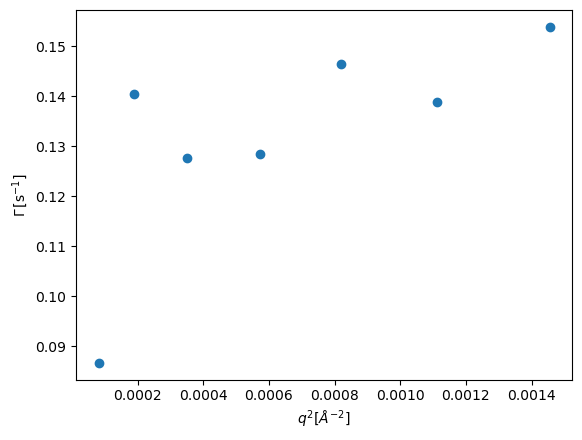

In [72]:
plt.scatter(qqdq[2:-2] ** 2, np.array(gms)[:-2] / 1e6)
plt.ylabel(r'$\Gamma \, [\mathrm{s}^{-1}]$')
plt.xlabel(r'$q^{2} [Å^{-2}]$')
#plt.xlim(0.0004, 0.0016)
#plt.ylim(0.2,0.25)

<ErrorbarContainer object of 3 artists>

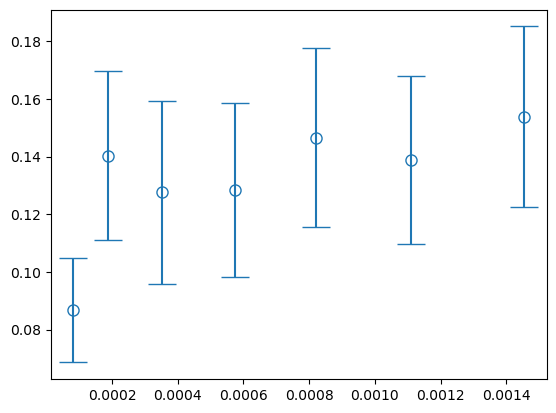

In [73]:
plt.errorbar(qqdq[2:-2] ** 2, np.array(gms[:-2]) / 1e6, yerr = np.array(uncs)[:-2] / 1e6,
            fmt = 'o',markersize = 8, markeredgewidth = 1, capsize = 10,
            markerfacecolor = 'None')


In [108]:
def exp(q, D,k):
    return (D * q ** 2 + k) 

def chi2(D,k):
    y = exp(qqdq[2:] * 1e10, D, k)
    chi2 = np.sum((np.array(gms) - y) ** 2 / (np.array(uncs)) ** 2)
    return chi2
    
fit_ds = Minuit(chi2, D = 1, k = 0.05)
fit_ds.migrad();
Ds = fit_ds.values
idk = fit_ds.errors
chii = fit_ds.fval

In [109]:
Ds

<ValueView D=2.714060739847084e-13 k=105879.83411548471>

In [110]:
ds_x = np.linspace(0, (max(qqdq)), 150)

In [111]:
ds_y = exp(ds_x * 1e10, *Ds) / 1e6

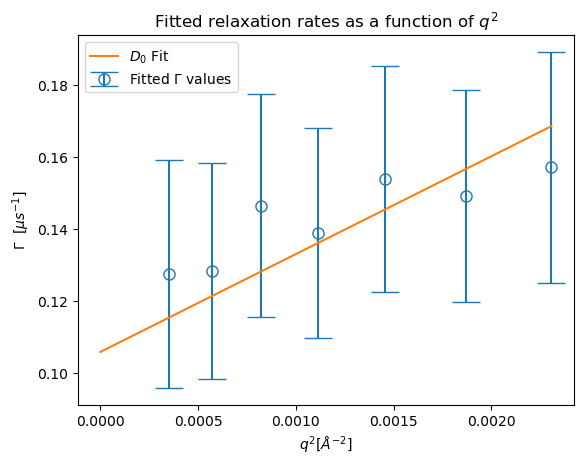

In [114]:
plt.errorbar(qqdq[4:] ** 2, np.array(gms[2:]) / 1e6, yerr = np.array(uncs[2:]) / 1e6,
            fmt = 'o',markersize = 8, markeredgewidth = 1, capsize = 10,
            markerfacecolor = 'None', label = r'Fitted $\Gamma$ values')
plt.plot(ds_x ** 2, ds_y, label = r'$D_{0}$ Fit')
plt.xlabel(r'$q^{2} [Å^{-2}]$')
plt.ylabel('$\Gamma$  [$\mu s^{-1}$]')
plt.legend()
plt.title(r'Fitted relaxation rates as a function of $q^{2}$')
plt.savefig('Ds_sim.png', dpi = 300)

In [124]:
Ds[0] * 1e12

0.2714060739847084

In [125]:
idk[0] * 1e12

0.12556862708275207

In [119]:
g2s - np.min(np.array(g2s))

array([[0.38922594, 0.35899163, 0.33182382, 0.3073371 , 0.28541692,
        0.26585024, 0.24756263, 0.23051389, 0.21516625, 0.2015992 ,
        0.18881939, 0.17793222, 0.16836754, 0.16034299, 0.15234048,
        0.1440559 , 0.13598513, 0.12884244, 0.12161892, 0.11420795,
        0.10725625, 0.10149393, 0.09592959, 0.09053699, 0.08583099,
        0.08155593, 0.07856659, 0.07606275, 0.07491696, 0.07314099,
        0.07073956, 0.06867019, 0.06588419, 0.06298922, 0.06001348,
        0.05722111, 0.05440283, 0.05152045, 0.04884393, 0.0451212 ,
        0.04090065, 0.03725628, 0.03445831, 0.03208795, 0.02967658,
        0.02751461, 0.02588392, 0.0245341 , 0.02312971, 0.02109793,
        0.02022568, 0.01961317, 0.019507  , 0.020075  , 0.01994283,
        0.0197262 , 0.01884738, 0.01776896, 0.01668382, 0.01548265,
        0.01615695, 0.01639201, 0.01599884, 0.01617864, 0.01607954,
        0.01605974, 0.01676118, 0.01888282, 0.0210753 , 0.02305281,
        0.02261246, 0.02305808, 0.02388153, 0.02